In [ ]:
!pip install plot_metric

**Import required libraries**

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA#, plot_roc_curve
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from plot_metric.functions import BinaryClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Setting max columns/rows display range
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

**Read data**

In [ ]:
train_data = pd.read_csv('../input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_data.shape

(891, 12)

In [ ]:
# Checking detail information about train data.
def getDatasetDetail(data) : 
    return pd.DataFrame({
                'Datatype' : data.dtypes.astype(str), 
                'Non_Null_Count': data.count(axis = 0).astype(int), 
                'Null_Count': data.isnull().sum().astype(int), 
                'Null_Percentage': round(data.isnull().sum()/len(data) * 100 , 2), 
                'Unique_Values_Count': data.nunique().astype(int) 
                 }).sort_values(by='Null_Percentage', ascending=False)

getDatasetDetail(train_data)

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
Cabin,object,204,687,77.10,147
Age,float64,714,177,19.87,88
Embarked,object,889,2,0.22,3
PassengerId,int64,891,0,0.00,891
Survived,int64,891,0,0.00,2
Pclass,int64,891,0,0.00,3
Name,object,891,0,0.00,891
Sex,object,891,0,0.00,2
SibSp,int64,891,0,0.00,7
Parch,int64,891,0,0.00,7


**Derive new variables**

Create a new varibles wheather based in cabin information

In [ ]:
train_data["CabinBool"] = (train_data["Cabin"].notnull().astype('int'))

Create a new variable using Name variable

In [ ]:
train_data['Name_title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [ ]:
train_data['Name_title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Name_title, dtype: int64

In [ ]:
train_data['Name_title'] = train_data['Name_title'].apply(lambda a: 'Other' if a not in ['Mr', 'Miss', 'Mrs', 'Master'] else a)

In [ ]:
train_data['Name_title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Name_title, dtype: int64

In [ ]:
def return_title(title, Age):
    if title != 'Mr':
        return title
    elif (title == 'Mr') & (Age > 25.0):
        return 'Mr1'
    else:
        return 'Mr2'

In [ ]:
#train_data[train_data['Name_title'] == 'Mr'].groupby('Age').count()['PassengerId']
train_data['Name_title'] = train_data[['Name_title', 'Age']].apply(lambda a: return_title(a.Name_title, a.Age), axis = 1)

Let's check title vs survival ratio

In [ ]:
train_data.groupby(['Name_title','Survived']).count()['PassengerId']

Name_title  Survived
Master      0            17
            1            23
Miss        0            55
            1           127
Mr1         0           205
            1            51
Mr2         0           231
            1            30
Mrs         0            26
            1            99
Other       0            15
            1            12
Name: PassengerId, dtype: int64

Create a new variable using Title variable

In [ ]:
train_data['Ticket_cls'] = train_data['Ticket'].apply(lambda a: a.split(' ')[0])

In [ ]:
train_data['Ticket_cls'] = train_data['Ticket_cls'].apply(lambda a: 'Numeric' if a.isnumeric() else 'Alphabet')

In [ ]:
def return_numeric(cls, Ticket):
    if cls != 'Numeric':
        return cls
    elif (cls == 'Numeric') & (int(Ticket) > 120000):
        return 'Numeric1'
    else:
        return 'Numeric2'

In [ ]:
train_data['Ticket_cls'] = train_data[['Ticket_cls', 'Ticket']].apply(lambda a: return_numeric(a.Ticket_cls, a.Ticket), axis = 1)

Let's check title vs survival ratio

In [ ]:
train_data.groupby(['Ticket_cls','Survived']).count()['PassengerId']

Ticket_cls  Survived
Alphabet    0           142
            1            88
Numeric1    0           259
            1           100
Numeric2    0           148
            1           154
Name: PassengerId, dtype: int64

Create new variable using SibSp and Parch variables

In [ ]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

In [ ]:
train_data['Solo_traveller'] = train_data['FamilySize'].apply(lambda a: 'Yes' if a == 1 else 'No')

**Data transformation**

Check the skewness on Age

Text(0.5, 1.0, 'Passenger Age Distribution')

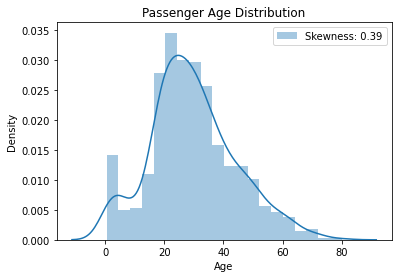

In [ ]:
sns.distplot(train_data['Age'], label = 'Skewness: %.2f'%(train_data['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

**Observation:** Skewness is fine for Age column

Check the skewness on Fare

Text(0, 0.5, 'Passenger Fare Distribution')

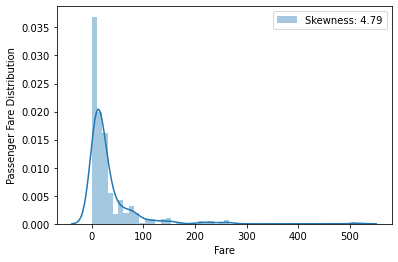

In [ ]:
sns.distplot(train_data['Fare'], label = 'Skewness: %.2f'%(train_data['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

**Observation:** Skewness is not good in this scenarion. So, in next step correcting it using log transformation

In [ ]:
train_data['norm_fare'] = np.log(train_data['Fare'] + 1)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

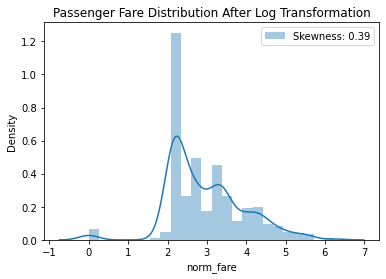

In [ ]:
sns.distplot(train_data['norm_fare'], label = 'Skewness: %.2f'%(train_data['norm_fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

**Observation:** Skewness is fine after using log transformation

**Fill missing values**

In [ ]:
#Function to handle missing values
def fill_Missing_Values(df):    
    # check missing values
    miss_col = df.isnull().sum()
    # filter for null value columns
    miss_col = miss_col[miss_col > 0]
    #Loop missing columns
    for column in miss_col.index:
        if df[column].dtype.name == 'object':
            # impute object type columns with mode
            df[column].fillna(df[column].mode()[0], inplace=True)
            
        elif df[column].dtype.name == 'float64' or df[column].dtype.name == 'int64' or df[column].dtype.name == 'int32':
            # impute numeric type columns with median
            df[column] = df[column].fillna((df[column].median()))
            
        else:
            print('Unable to handle: ', column)
            
    return df

In [ ]:
train_data = fill_Missing_Values(train_data)

In [ ]:
getDatasetDetail(train_data)

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
PassengerId,int64,891,0,0.0,891
Survived,int64,891,0,0.0,2
Solo_traveller,object,891,0,0.0,2
FamilySize,int64,891,0,0.0,9
Ticket_cls,object,891,0,0.0,3
Name_title,object,891,0,0.0,6
CabinBool,int64,891,0,0.0,2
Embarked,object,891,0,0.0,3
Cabin,object,891,0,0.0,147
Fare,float64,891,0,0.0,248


**Handle outliers**

In [ ]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [ ]:
# #Get all numeric columns
numCol = train_data.select_dtypes(exclude=['object']).columns

In [ ]:
#Cap all Outliers
for col in numCol:
    arr = cap_outliers(train_data[col])
    train_data[col] = arr

**Data Visualization**

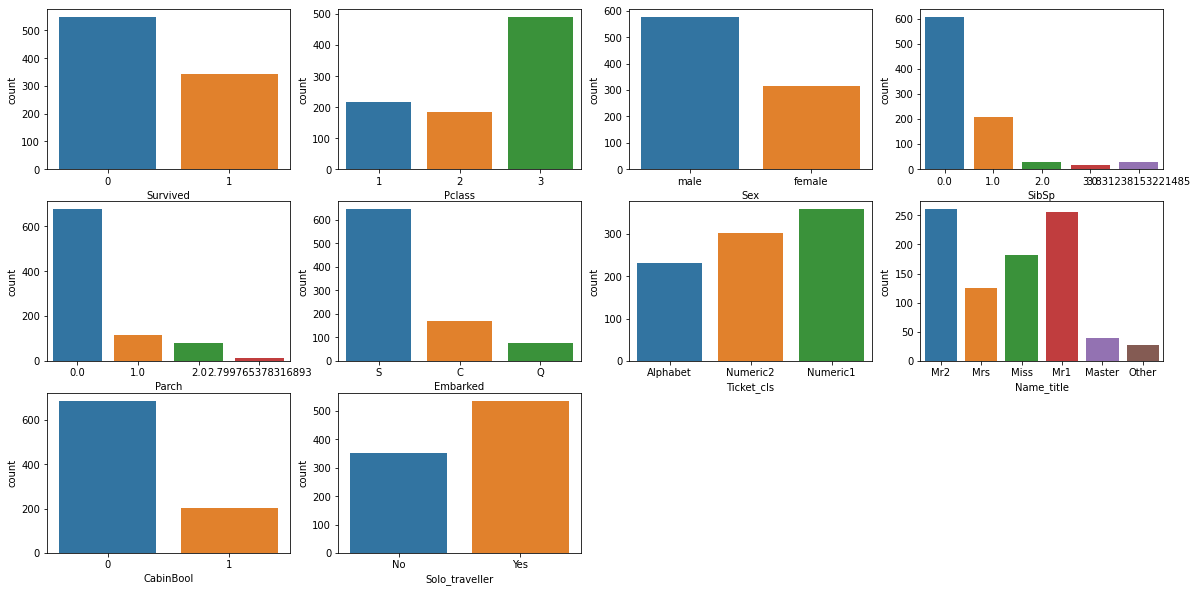

In [ ]:
plt.figure(figsize=(20, 10))
rows = int(math.ceil(len(['Survived','Pclass','Sex','SibSp','Parch','Embarked', 'Ticket_cls', 'Name_title', 'CabinBool', 'Solo_traveller'])/4))
cols = 4
for i,n in enumerate(['Survived','Pclass','Sex','SibSp','Parch','Embarked', 'Ticket_cls', 'Name_title', 'CabinBool', 'Solo_traveller']):
    plt.subplot(rows, cols, i+1)
    sns.countplot(x=n, data= train_data)
plt.show()

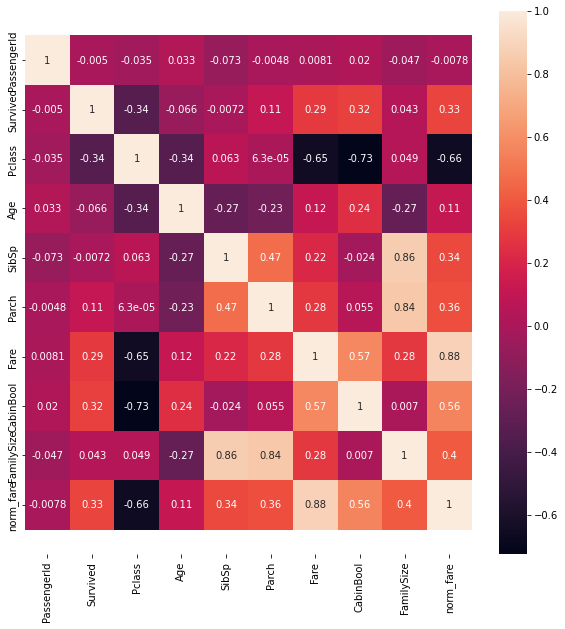

In [ ]:
#Heatmap
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(train_data.corr(), 
            xticklabels=train_data.corr().columns.values,
            yticklabels=train_data.corr().columns.values,annot= True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

**Observation:** There are no highlily correlated variables(>95% correlation).

**Create dummies for the categorical variables**

In [ ]:
categorical_cols = train_data.select_dtypes(include = "object").columns
print (categorical_cols)

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Name_title',
       'Ticket_cls', 'Solo_traveller'],
      dtype='object')


In [ ]:
getDatasetDetail(train_data)

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
PassengerId,int64,891,0,0.0,891
Survived,int64,891,0,0.0,2
Solo_traveller,object,891,0,0.0,2
FamilySize,float64,891,0,0.0,7
Ticket_cls,object,891,0,0.0,3
Name_title,object,891,0,0.0,6
CabinBool,int64,891,0,0.0,2
Embarked,object,891,0,0.0,3
Cabin,object,891,0,0.0,147
Fare,float64,891,0,0.0,241


In [ ]:
# Creating dummies for categorical variables
categorical_cols = ['Sex', 'Name_title', 'Ticket_cls', 'Embarked', 'Solo_traveller', 'CabinBool', 'Parch', 'SibSp', 'Pclass']
dummies = pd.get_dummies(train_data[categorical_cols],drop_first=True)
# Drop Categorical columns
train_data.drop(categorical_cols,axis=1,inplace=True)
# Concatenate original dataframe and dummies
train_data = pd.concat([train_data,dummies],axis=1)

In [ ]:
train_data.head()

,PassengerId,Survived,Name,Age,Ticket,Fare,Cabin,FamilySize,norm_fare,CabinBool,Parch,SibSp,Pclass,Sex_male,Name_title_Miss,Name_title_Mr1,Name_title_Mr2,Name_title_Mrs,Name_title_Other,Ticket_cls_Numeric1,Ticket_cls_Numeric2,Embarked_Q,Embarked_S,Solo_traveller_Yes
0,1,0,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,B96 B98,2.0,2.110213,0,0.0,1.0,3,1,0,0,1,0,0,0,0,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,C85,2.0,4.280593,1,0.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,B96 B98,1.0,2.188856,0,0.0,0.0,3,0,1,0,0,0,0,0,0,0,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,C123,2.0,3.990834,1,0.0,1.0,1,0,0,0,0,1,0,0,1,0,1,0
4,5,0,"Allen, Mr. William Henry",35.0,373450,8.0500,B96 B98,1.0,2.202765,0,0.0,0.0,3,1,0,1,0,0,0,1,0,0,1,1


**Remove unnecessary columns**

In [ ]:
train_data.drop(['PassengerId', 'Cabin', 'Ticket', 'Name', 'Fare', 'FamilySize'], axis = 1, inplace = True)

In [ ]:
getDatasetDetail(train_data)

,Datatype,Non_Null_Count,Null_Count,Null_Percentage,Unique_Values_Count
Survived,int64,891,0,0.0,2
Age,float64,891,0,0.0,84
Embarked_S,uint8,891,0,0.0,2
Embarked_Q,uint8,891,0,0.0,2
Ticket_cls_Numeric2,uint8,891,0,0.0,2
Ticket_cls_Numeric1,uint8,891,0,0.0,2
Name_title_Other,uint8,891,0,0.0,2
Name_title_Mrs,uint8,891,0,0.0,2
Name_title_Mr2,uint8,891,0,0.0,2
Name_title_Mr1,uint8,891,0,0.0,2


**Splitting dataset**

In [ ]:
X = train_data.drop("Survived",1)
y = train_data.Survived

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, stratify=y, random_state=42)

In [ ]:
X_train.shape

(712, 17)

**Scaling dataset**

In [ ]:
#Scaling and transform train Dataset
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_sc, columns=X_train.columns)

In [ ]:
X_train_scaled.head()

,Age,norm_fare,CabinBool,Parch,SibSp,Pclass,Sex_male,Name_title_Miss,Name_title_Mr1,Name_title_Mr2,Name_title_Mrs,Name_title_Other,Ticket_cls_Numeric1,Ticket_cls_Numeric2,Embarked_Q,Embarked_S,Solo_traveller_Yes
0,-0.110291,1.132146,-0.538382,-0.508116,-0.528596,0.829568,0.742427,-0.496926,-0.633699,1.556624,-0.420547,-0.174329,-0.807448,1.397983,-0.289333,0.611978,0.800346
1,-0.110291,-2.978009,-0.538382,-0.508116,-0.528596,-0.370945,0.742427,-0.496926,-0.633699,1.556624,-0.420547,-0.174329,1.238470,-0.715316,-0.289333,0.611978,0.800346
2,-0.110291,2.525096,1.857418,-0.508116,-0.528596,-1.571457,0.742427,-0.496926,-0.633699,1.556624,-0.420547,-0.174329,-0.807448,-0.715316,-0.289333,0.611978,0.800346
3,-0.885142,-0.631295,-0.538382,0.894146,-0.528596,0.829568,-1.346933,-0.496926,-0.633699,-0.642416,2.377857,-0.174329,1.238470,-0.715316,-0.289333,0.611978,-1.249460
4,0.122165,0.364275,-0.538382,0.894146,0.632585,-0.370945,-1.346933,-0.496926,-0.633699,-0.642416,2.377857,-0.174329,-0.807448,-0.715316,-0.289333,0.611978,-1.249460


In [ ]:
#Transform test dataset
X_test_sc = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [ ]:
X_test_scaled.head()

,Age,norm_fare,CabinBool,Parch,SibSp,Pclass,Sex_male,Name_title_Miss,Name_title_Mr1,Name_title_Mr2,Name_title_Mrs,Name_title_Other,Ticket_cls_Numeric1,Ticket_cls_Numeric2,Embarked_Q,Embarked_S,Solo_traveller_Yes
0,-0.420231,0.281801,-0.538382,-0.508116,1.793765,0.829568,0.742427,-0.496926,-0.633699,1.556624,-0.420547,-0.174329,-0.807448,-0.715316,-0.289333,0.611978,-1.249460
1,1.129472,-0.114938,-0.538382,0.894146,-0.528596,0.829568,0.742427,-0.496926,1.578036,-0.642416,-0.420547,-0.174329,1.238470,-0.715316,-0.289333,0.611978,-1.249460
2,-0.575201,-0.867632,-0.538382,-0.508116,-0.528596,0.829568,0.742427,-0.496926,-0.633699,1.556624,-0.420547,-0.174329,-0.807448,1.397983,-0.289333,-1.634045,0.800346
3,0.897016,-0.242291,-0.538382,-0.508116,1.793765,0.829568,0.742427,-0.496926,1.578036,-0.642416,-0.420547,-0.174329,1.238470,-0.715316,-0.289333,0.611978,-1.249460
4,-0.110291,-0.151671,-0.538382,-0.508116,0.632585,0.829568,-1.346933,2.012373,-0.633699,-0.642416,-0.420547,-0.174329,1.238470,-0.715316,3.456220,-1.634045,-1.249460


**Model Building**

In [ ]:
# Following function will be used for different models evaluation
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_sc = round(accuracy_score(actual, pred)*100,2)
    
    # Precision score
    prec_sc = round(precision_score(actual, pred)*100,2)
    
    # Recall score
    rec_sc = round(recall_score(actual, pred)*100,2)
    
    # Confusion matrix
    confusion_m = confusion_matrix(actual, pred)
   
    TP = confusion_m[1,1] # true positive 
    TN = confusion_m[0,0] # true negatives
    FP = confusion_m[0,1] # false positives
    FN = confusion_m[1,0] # false negatives
    # Specificity
    Specificity= round(TN / float(TN+FP),2)
    # ROC AUC score
    roc_score = round(recall_score(actual, pred)*100,2)
    #F1-Score
    f1_score=round(2*((prec_sc*rec_sc)/(prec_sc+rec_sc)),2)
    return {"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Recall":rec_sc,"Precision":prec_sc,"Specificity":Specificity,"ROC/AUC Score":roc_score,"F1-Score":f1_score, "Accuracy": acc_sc}

In [ ]:
# Build Logistic Regression using important features
# Initialize the Logistic regression
model_lg = LogisticRegression(random_state=42)
# fit the training data
model_lg.fit(X_train_scaled, y_train)
# predict the training data
Y_train_pred = model_lg.predict(X_train_scaled)
# predict the testing data
Y_test_pred = model_lg.predict(X_test_scaled)

In [ ]:
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,205,384,55,68,75.09,78.85,0.87,75.09,76.92,82.72
test_data,53,96,14,16,76.81,79.10,0.87,76.81,77.94,83.24


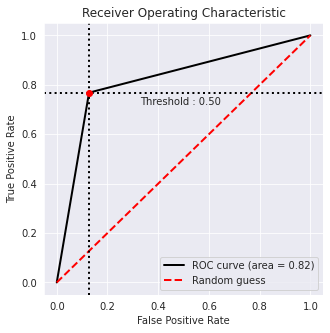

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [ ]:
# Creating KFold object with 10 splits
folds = KFold(n_splits=10, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [ ]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.013272,0.001253,0.005451,0.000101,0.01,{'C': 0.01},0.85,0.617647,0.739130,0.71875,0.777778,0.545455,0.708333,0.53125,0.625000,0.666667,0.678001,0.095677,6,0.687747,0.690377,0.684,0.672199,0.695122,0.716667,0.694779,0.701245,0.706827,0.690763,0.693973,0.011707
1,0.018785,0.000426,0.005508,0.000205,0.1,{'C': 0.1},0.85,0.676471,0.782609,0.78125,0.777778,0.606061,0.750000,0.65625,0.750000,0.708333,0.733875,0.068456,5,0.747036,0.736402,0.748,0.742739,0.752033,0.754167,0.751004,0.755187,0.751004,0.755020,0.749259,0.005662
2,0.022470,0.000619,0.005296,0.000275,1,{'C': 1},0.90,0.735294,0.782609,0.78125,0.777778,0.636364,0.791667,0.65625,0.750000,0.708333,0.751954,0.071179,1,0.747036,0.744770,0.744,0.738589,0.760163,0.783333,0.759036,0.755187,0.767068,0.763052,0.756223,0.012648
3,0.026478,0.001043,0.005563,0.000183,10,{'C': 10},0.85,0.705882,0.782609,0.78125,0.740741,0.636364,0.791667,0.68750,0.708333,0.708333,0.739268,0.059117,2,0.747036,0.740586,0.740,0.734440,0.760163,0.770833,0.751004,0.751037,0.759036,0.742972,0.749711,0.010532
4,0.028350,0.001834,0.005637,0.000263,100,{'C': 100},0.85,0.705882,0.782609,0.78125,0.740741,0.636364,0.791667,0.68750,0.708333,0.708333,0.739268,0.059117,2,0.747036,0.740586,0.740,0.734440,0.756098,0.770833,0.742972,0.751037,0.759036,0.742972,0.748501,0.010343
5,0.031621,0.001411,0.005740,0.000327,1000,{'C': 1000},0.85,0.705882,0.782609,0.78125,0.740741,0.636364,0.791667,0.68750,0.708333,0.708333,0.739268,0.059117,2,0.747036,0.740586,0.740,0.734440,0.756098,0.770833,0.742972,0.751037,0.759036,0.746988,0.748903,0.010198


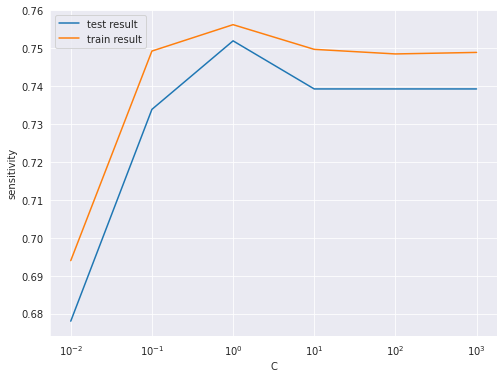

In [ ]:
# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [ ]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.7519544227440647 at C = 1


In [ ]:
# Instantiate the model with best C
logistic_1 = LogisticRegression(class_weight='balanced',C=best_C)

# Fit the model on the train set
log_1_model = logistic_1.fit(X_train_scaled, y_train)

# predict the training data
Y_train_pred = log_1_model.predict(X_train_scaled)
# predict the testing data
Y_test_pred = log_1_model.predict(X_test_scaled)

In [ ]:
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,222,357,82,51,81.32,73.03,0.81,81.32,76.95,81.32
test_data,58,89,21,11,84.06,73.42,0.81,84.06,78.38,82.12


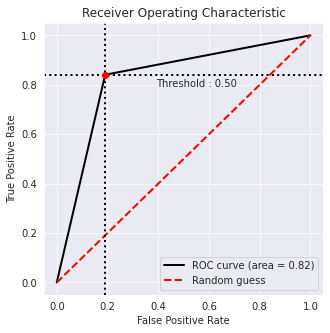

In [ ]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Decision Tree**

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(10,20,10),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced',random_state=42)

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': range(10, 20, 10),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [ ]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003647,0.000290,0.002418,0.000130,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.800000,0.727273,0.836364,0.888889,0.851852,0.820875,0.054813,1
1,0.003655,0.000127,0.002407,0.000051,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.800000,0.727273,0.836364,0.888889,0.851852,0.820875,0.054813,1
2,0.003146,0.000042,0.002270,0.000017,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.709091,0.545455,0.763636,0.703704,0.722222,0.688822,0.074698,3
3,0.003179,0.000042,0.002331,0.000029,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.709091,0.545455,0.763636,0.703704,0.722222,0.688822,0.074698,3


In [ ]:
# Printing the optimal sensitivity score and hyperparameters
print("Best score:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best score:- 0.820875420875421
DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)


In [ ]:
# Instantiate the model with best hyperparameters
dt = DecisionTreeClassifier(class_weight='balanced', criterion = "gini",max_depth=10,
                       min_samples_leaf=50, min_samples_split=50,
                       random_state=42)

# Fit the model on the train set
dt_model = dt.fit(X_train_scaled, y_train)

# predict the training data
Y_train_pred = dt_model.predict(X_train_scaled)
# predict the testing data
Y_test_pred = dt_model.predict(X_test_scaled)
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,205,366,73,68,75.09,73.74,0.83,75.09,74.41,80.20
test_data,47,83,27,22,68.12,63.51,0.75,68.12,65.73,72.63


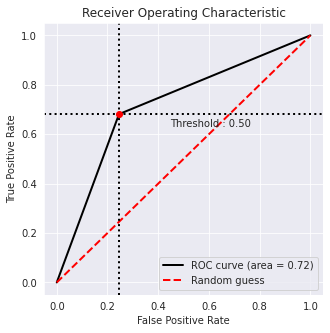

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**RandomForest Model**

In [ ]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(10,20,10),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'max_features': [7],
    'n_estimators':[300]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           verbose = 1, 
                           scoring='recall',
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': range(10, 20, 10), 'max_features': [7],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [300]},
             return_train_score=True, scoring='recall', verbose=1)

In [ ]:
print("Best Score",grid_search.best_score_)
print("Best Params",grid_search.best_params_)

Best Score 0.7362637362637363
Best Params {'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 300}


In [ ]:
# Instantiate the model with best hyperparameters
rfc = RandomForestClassifier(class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=7,
                             n_estimators=300,
                       random_state=42)

# Fit the model on the train set
rfc_model = rfc.fit(X_train_scaled, y_train)

# predict the training data
Y_train_pred = rfc_model.predict(X_train_scaled)
# predict the testing data
Y_test_pred = rfc_model.predict(X_test_scaled)
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,208,364,75,65,76.19,73.50,0.83,76.19,74.82,80.34
test_data,50,84,26,19,72.46,65.79,0.76,72.46,68.96,74.86


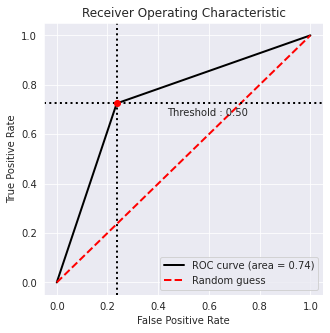

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**SVC**

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 8, 9, 10, 100], 
              'gamma': [1, 0.1 , 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 

svc = svm.SVC()
grid_search = GridSearchCV(svc, param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.613 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.620 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.620 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.804 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.811 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.838 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.831 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.796 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.804 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 9, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [ ]:
print("Best Score",grid_search.best_score_)
print("Best Params",grid_search.best_params_)

Best Score 0.8300502314586822
Best Params {'C': 8, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
# Instantiate the model with best hyperparameters
svc = svm.SVC(C=8, gamma = 0.01, kernel = 'rbf', random_state=42)

# Fit the model on the train set
svc_model = svc.fit(X_train_scaled, y_train)

# predict the training data
Y_train_pred = svc_model.predict(X_train_scaled)
# predict the testing data
Y_test_pred = svc_model.predict(X_test_scaled)
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,204,398,41,69,74.73,83.27,0.91,74.73,78.77,84.55
test_data,51,97,13,18,73.91,79.69,0.88,73.91,76.69,82.68


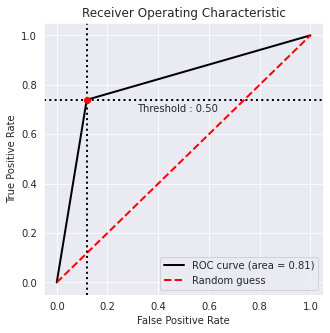

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Gradient Boosting**

In [ ]:
gbm = GradientBoostingClassifier(random_state=100)
gbm.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 100,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
gbm.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=100)

In [ ]:
# predict the training data
Y_train_pred = gbm.predict(X_train_scaled)
# predict the testing data
Y_test_pred = gbm.predict(X_test_scaled)
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,231,420,19,42,84.62,92.40,0.96,84.62,88.34,91.43
test_data,44,96,14,25,63.77,75.86,0.87,63.77,69.29,78.21


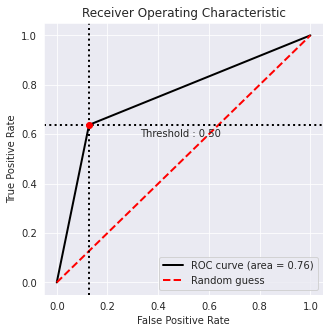

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Adaboost**

In [ ]:
adaboost =  AdaBoostClassifier(n_estimators=200, random_state=1)
adaboost.fit(X_train_scaled, y_train)

AdaBoostClassifier(n_estimators=200, random_state=1)

In [ ]:
# predict the training data
Y_train_pred = adaboost.predict(X_train_scaled)
# predict the testing data
Y_test_pred = adaboost.predict(X_test_scaled)
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,218,397,42,55,79.85,83.85,0.90,79.85,81.80,86.38
test_data,46,92,18,23,66.67,71.88,0.84,66.67,69.18,77.09


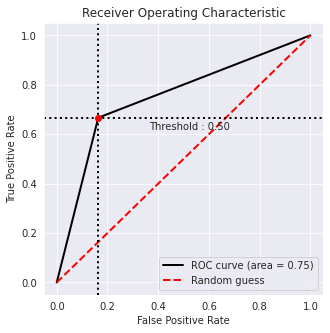

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Neural network**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, GRU, Embedding
from keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
model = Sequential()
model.add(Dense(32,  activation = 'relu', input_dim = 17))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1))
#Complile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

2022-09-24 14:20:49.514954: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
#model.fit(X_train_scaled, y_train, batch_size = 10, epochs = 100, validation_data=(X_test_scaled, y_test))

In [ ]:
model.fit(X_train_scaled, y_train, batch_size = 10, epochs = 100)

2022-09-24 14:20:49.966264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
72/72 [==============================] - 1s 2ms/step - loss: 1.1816 - accuracy: 0.7065
Epoch 2/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8963 - accuracy: 0.8062
Epoch 3/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8179 - accuracy: 0.8202
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8222 - accuracy: 0.8216
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8292 - accuracy: 0.8287
Epoch 6/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8009 - accuracy: 0.8329
Epoch 7/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7862 - accuracy: 0.8511
Epoch 8/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8609 - accuracy: 0.8062
Epoch 9/100
72/72 [==============================] - 0s 2ms/step - loss: 0.8635 - accuracy: 0.8258
Epoch 10/100
72/72 [==============================] - 0s 2ms/step - loss: 0.7243 - accuracy: 0.8497
Epoch 11/

In [ ]:
# predict the training data
Y_train_pred = model.predict(X_train_scaled)
# predict the testing data
Y_test_pred = model.predict(X_test_scaled)

In [ ]:
Y_train_pred = [1 if a[0]> 0.50 else 0 for a in Y_train_pred]
Y_test_pred = [1 if a[0]> 0.50 else 0 for a in Y_test_pred]

In [ ]:
# Model evaluation
train_eval=pd.DataFrame([evaluate_model(y_train, Y_train_pred)])
test_eval=pd.DataFrame([evaluate_model(y_test, Y_test_pred)])
df_eval=pd.concat([train_eval,test_eval])
df_eval['data']=['train_data','test_data']
df_eval.set_index('data',inplace=True)

In [ ]:
df_eval

,TP,TN,FP,FN,Recall,Precision,Specificity,ROC/AUC Score,F1-Score,Accuracy
data,,,,,,,,,,
train_data,227,422,17,46,83.15,93.03,0.96,83.15,87.81,91.15
test_data,49,96,14,20,71.01,77.78,0.87,71.01,74.24,81.01


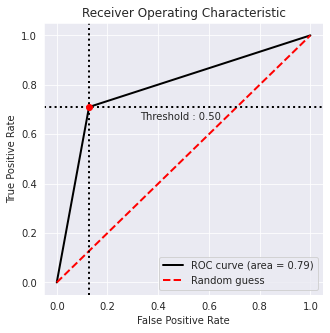

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, Y_test_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Model Summaries**

In [ ]:
df=pd.DataFrame({"Experiment No":[1,2,3,4,5,6,7,8],"Model":["Logistic", "Logistic with Grid search", "Decision Tree", "Random Forest", "Support Vector Classifier", "Gradient bossting", "Adaboost", "Neural Networks"],
                 "Train Accuracy":[82.72, 81.32, 80.20, 80.34, 84.55, 91.43, 86.38, 90.31],"Validation Accuracy":[83.24, 82.12, 72.63, 74.86, 82.68, 78.21, 77.09, 78.77],
                 "Observation":["Eventhough model was given better accuracy but not given good result on unseen data provided by kaggle","Eventhough model was given better accuracy but not given good result on unseen data provided by kaggle", 
                                "ot producing good results on unseen data provided by kaggle", "Not producing good results on unseen data provided by kaggle", "Produced good resutls with good accuracy on train and test datasets","Overfitting", "Overfitting","Overfitting"]})

In [ ]:
df.style.set_properties(subset=['Observation'], **{'width': '600px'})

,Experiment No,Model,Train Accuracy,Validation Accuracy,Observation
0,1,Logistic,82.720000,83.240000,Eventhough model was given better accuracy but not given good result on unseen data provided by kaggle
1,2,Logistic with Grid search,81.320000,82.120000,Eventhough model was given better accuracy but not given good result on unseen data provided by kaggle
2,3,Decision Tree,80.200000,72.630000,ot producing good results on unseen data provided by kaggle
3,4,Random Forest,80.340000,74.860000,Not producing good results on unseen data provided by kaggle
4,5,Support Vector Classifier,84.550000,82.680000,Produced good resutls with good accuracy on train and test datasets
5,6,Gradient bossting,91.430000,78.210000,Overfitting
6,7,Adaboost,86.380000,77.090000,Overfitting
7,8,Neural Networks,90.310000,78.770000,Overfitting


**Model Prediction On Test Data**

Read the test data and apply all preprocessing steps preformed on training data

In [ ]:
test_data = pd.read_csv('../input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
test = test_data.copy()

In [ ]:
test_data["CabinBool"] = (test_data["Cabin"].notnull().astype('int'))
test_data['Name_title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Name_title'] = test_data['Name_title'].apply(lambda a: 'Other' if a not in ['Mr', 'Miss', 'Mrs', 'Master'] else a)

In [ ]:
test_data['Name_title'] = test_data[['Name_title', 'Age']].apply(lambda a: return_title(a.Name_title, a.Age), axis = 1)

In [ ]:
test_data['Ticket_cls'] = test_data['Ticket'].apply(lambda a: a.split(' ')[0])
test_data['Ticket_cls'] = test_data['Ticket_cls'].apply(lambda a: 'Numeric' if a.isnumeric() else 'Alphabet')
test_data['Ticket_cls'] = test_data[['Ticket_cls', 'Ticket']].apply(lambda a: return_numeric(a.Ticket_cls, a.Ticket), axis = 1)
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['Solo_traveller'] = test_data['FamilySize'].apply(lambda a: 'Yes' if a == 1 else 'No')

In [ ]:
#test_data['norm_fare'] = test_data['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

test_data['norm_fare'] = np.log(test_data['Fare'] + 1)

In [ ]:
test_data = fill_Missing_Values(test_data)

In [ ]:
# Creating dummies for categorical variables
categorical_cols = ['Sex', 'Name_title', 'Ticket_cls', 'Embarked', 'Solo_traveller', 'CabinBool', 'Parch', 'SibSp', 'Pclass']
dummies = pd.get_dummies(test_data[categorical_cols],drop_first=True)
# Drop Categorical columns
test_data.drop(categorical_cols,axis=1,inplace=True)
# Concatenate original dataframe and dummies
test_data = pd.concat([test_data,dummies],axis=1)

In [ ]:
# Drop previously dropped columns
test_data.drop(['PassengerId', 'Cabin', 'Ticket', 'Name', 'Fare', 'FamilySize'], axis = 1, inplace = True)

In [ ]:
test_data_sc = scaler.transform(test_data)
test_data_scaled = pd.DataFrame(test_data_sc, columns=test_data.columns)

In [ ]:
test_data_scaled.head()

,Age,norm_fare,CabinBool,Parch,SibSp,Pclass,Sex_male,Name_title_Miss,Name_title_Mr1,Name_title_Mr2,Name_title_Mrs,Name_title_Other,Ticket_cls_Numeric1,Ticket_cls_Numeric2,Embarked_Q,Embarked_S,Solo_traveller_Yes
0,0.393363,-0.794732,-0.538382,-0.508116,-0.528596,0.829568,0.742427,-0.496926,1.578036,-0.642416,-0.420547,-0.174329,1.23847,-0.715316,3.456220,-1.634045,0.800346
1,1.361927,-0.896157,-0.538382,-0.508116,0.632585,0.829568,-1.346933,-0.496926,-0.633699,-0.642416,2.377857,-0.174329,1.23847,-0.715316,-0.289333,0.611978,-1.249460
2,2.524205,-0.598295,-0.538382,-0.508116,-0.528596,-0.370945,0.742427,-0.496926,1.578036,-0.642416,-0.420547,-0.174329,1.23847,-0.715316,3.456220,-1.634045,0.800346
3,-0.187776,-0.701982,-0.538382,-0.508116,-0.528596,0.829568,0.742427,-0.496926,1.578036,-0.642416,-0.420547,-0.174329,1.23847,-0.715316,-0.289333,0.611978,0.800346
4,-0.575201,-0.374360,-0.538382,0.894146,0.632585,0.829568,-1.346933,-0.496926,-0.633699,-0.642416,2.377857,-0.174329,1.23847,-0.715316,-0.289333,0.611978,-1.249460


Using SVC model generating predictions on test data

In [ ]:
tes_pred = svc_model.predict(test_data_scaled)

In [ ]:
#Need to use for NN model
#tes_pred = [1 if a[0]> 0.50 else 0 for a in tes_pred]

In [ ]:
df_survived = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived': tes_pred})

Printing top 10 predictions

In [ ]:
df_survived.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
